In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import QuantLib as ql
import numpy as np
from dateutil.relativedelta import relativedelta

In [2]:
# plot data. If multiple lines, pass them in a list
def plot(data):
    fig, ax = plt.subplots()
    if isinstance(data, list):
        for d in data:
            plt.plot(d)
    else:
        plt.plot(data)
    plt.axhline(y=0, lw=.75, c='k')
    plt.grid()
    plt.show()

## Import LIBOR rates

In [3]:
# import libor rates
libor = pd.read_csv('data/datastream_rates.csv', index_col=0) / 100
libor.index = pd.to_datetime(libor.index)

## Create ACT/360 and ACT/365 year fractions for 3m, 1y and 3y tenors
GBP LIBOR uses the ACT/365 convention

In [4]:
yearfrac = pd.DataFrame(index = libor.index, columns=['3m_act360', '3m_act365', '1y_act360', '1y_act365', '3y_act360', '3y_act365'])

for index, row in yearfrac.iterrows():
    d0 = ql.Date(index.day, index.month, index.year)
    d3m_temp = index + relativedelta(months=3)
    d1y_temp = index + relativedelta(months=12)
    d3y_temp = index + relativedelta(months=36)
    # convert to quantlib dates
    d3m = ql.Date(d3m_temp.day, d3m_temp.month, d3m_temp.year)
    d1y = ql.Date(d1y_temp.day, d1y_temp.month, d1y_temp.year)
    d3y = ql.Date(d3y_temp.day, d3y_temp.month, d3y_temp.year)
    
    yearfrac.loc[index, '3m_act360'] = ql.Actual360().yearFraction(d0, d3m)
    yearfrac.loc[index, '3m_act365'] = yearfrac.loc[index, '3m_act360'] * 360 / 365
    
    yearfrac.loc[index, '1y_act360'] = ql.Actual360().yearFraction(d0, d1y)
    yearfrac.loc[index, '1y_act365'] = yearfrac.loc[index, '1y_act360'] * 360 / 365
    
    yearfrac.loc[index, '3y_act360'] = ql.Actual360().yearFraction(d0, d3y)
    yearfrac.loc[index, '3y_act365'] = yearfrac.loc[index, '3y_act360'] * 360 / 365

## Import data
First use WM Reuters fx rates

In [5]:
# import fx spot & forwards
fx = pd.read_csv('data/datastream_fx_wmr.csv', index_col=0)
fx.index = pd.to_datetime(fx.index)

### USD/EUR 3 month basis

In [6]:
tenor = '3m'

spot =  1 / fx['eurusd']
fwd = 1 / fx['eurusd' + tenor]
rf = libor['libusd' + tenor] * yearfrac[tenor + '_act360']
r = libor['libeur' + tenor] * yearfrac[tenor + '_act360']
basis_usdeur = 100*100*( (1 + rf) * fwd / spot  - (1+r) )

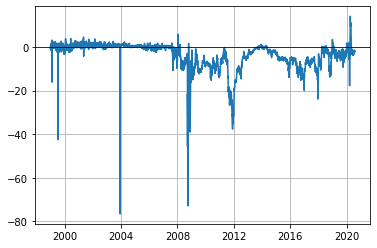

In [7]:
#basis = basis['2006-01-01':'2016-12-31']
plot(basis_usdeur)

### USD/JPY 3 month basis

In [8]:
tenor = '3m'

spot =  fx['usdjpy']
fwd = fx['usdjpy' + tenor]
r = libor['libjpy' + tenor] * yearfrac[tenor + '_act360']
rf = libor['libusd' + tenor] * yearfrac[tenor + '_act360']
basis_usdjpy = 100*100*( (1 + rf) * fwd / spot  - (1+r) )

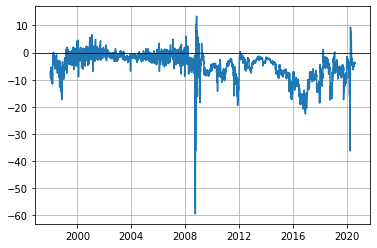

In [9]:
plot(basis_usdjpy)

## Now try the same with Refinitiv FX data

In [10]:
# import fx spot & forwards
fx_refin = pd.read_csv('data/datastream_fx_refinitiv.csv', index_col=0)
fx_refin.index = pd.to_datetime(fx_refin.index)

### USD/EUR 3 month basis, refinitiv data

In [11]:
tenor = '3m'

spot =  1 / fx_refin['eurusd']
fwd = 1 / fx_refin['eurusd' + tenor]
rf = libor['libusd' + tenor] * yearfrac[tenor + '_act360']
r = libor['libeur' + tenor] * yearfrac[tenor + '_act360']
basis_usdeur_refin = 100*100*( (1 + rf) * fwd / spot  - (1+r) )

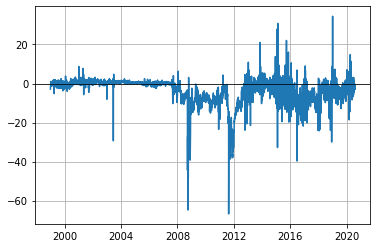

In [12]:
plot(basis_usdeur_refin)

Refinitiv data makes the basis much more volatile

### USD/JPY 3 month basis, refinitiv data

In [13]:
tenor = '3m'

spot =  fx_refin['usdjpy']
fwd = fx_refin['usdjpy' + tenor]
r = libor['libjpy' + tenor] * yearfrac[tenor + '_act360']
rf = libor['libusd' + tenor] * yearfrac[tenor + '_act360']
basis_usdjpy_refin = 100*100*( (1 + rf) * fwd / spot  - (1+r) )

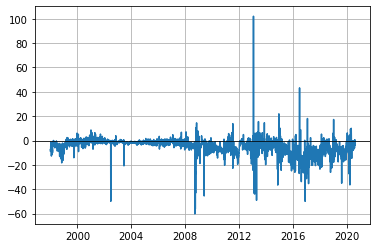

In [14]:
plot(basis_usdjpy_refin)

## Compare WM Reuters with refinitiv data

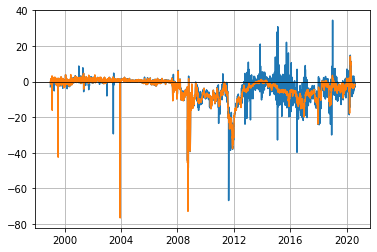

In [15]:
plot([basis_usdeur_refin, basis_usdeur])

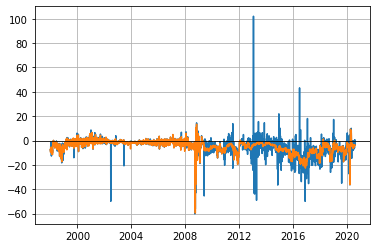

In [16]:
plot([basis_usdjpy_refin, basis_usdjpy])

Especially the usd/jpy pair is considerably off. 